In [1]:

from pathlib import Path
import itertools
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.plotting.matrix_plotting import _reorder_matrix

In [2]:
logging.basicConfig(
    level=logging.INFO,          # change to DEBUG for very verbose output
    format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

In [3]:
# Try to grab the canonical order from your package; fall back to a hard‑coded list
try:
    from fmriprep_denoise.visualization import utils       # present in your code base
    STRATEGIES = list(utils.GRID_LOCATION.values())
except Exception:
    STRATEGIES = [
        "baseline", "simple", "simple+gsr",
        "scrubbing.5", "scrubbing.5+gsr",
        "compcor", "aroma", "scrubbing.5+wmcsf", "simple+wmcsf"
    ]

logger.info(f"Using strategy list: {STRATEGIES}")

2025-05-09 15:30:50,442 - INFO - Using strategy list: ['baseline', 'simple', 'simple+gsr', 'scrubbing.5', 'scrubbing.5+gsr', 'compcor', 'aroma', 'scrubbing.5+wmcsf', 'simple+wmcsf']


In [4]:
def load_connectome_similarity(path_root: Path,
                               datasets: list[str],
                               fmriprep_version: str) -> dict[str, pd.DataFrame]:
    """
    Parameters
    ----------
    path_root         : Path to the *top* of your metrics tree.
                        Expected layout:
                        {path_root}/{dataset}/{fmriprep_version}/...*_connectome.tsv
    datasets          : List of BIDS‑like dataset names (e.g. ["ds000228"]).
    fmriprep_version  : Folder name used in the tree (e.g. "fmriprep-25.0.0").

    Returns
    -------
    dict {dataset → reordered average correlation DataFrame}
    """
    average_connectomes = {}

    for dset in datasets:
        logger.info(f"Dataset {dset}: searching for connectome TSVs")
        corr_mats = []

        # Walk through every *_connectome.tsv file
        for tsv in (path_root / dset / fmriprep_version).glob("*connectome.tsv"):
            df = pd.read_csv(tsv, sep="\t", index_col=0)
            # keep *only* the strategy columns in the canonical order
            cc = df[STRATEGIES]
            corr_mats.append(cc.corr().values)
            logger.debug(f"{tsv.name} corr matrix shape: {corr_mats[-1].shape}")

        if not corr_mats:
            raise RuntimeError(f"No connectome TSVs found for {dset}")

        # Mean across all files for this dataset
        avg = np.mean(corr_mats, axis=0)
        avg_df = pd.DataFrame(avg, columns=STRATEGIES, index=STRATEGIES)
        average_connectomes[dset] = avg_df

    # ---------- cluster reorder (global across datasets) ----------
    logger.info("Computing global ordering for heat‑map rows/cols")
    grand_avg = np.mean([df.values for df in average_connectomes.values()], axis=0)
    _, ordered_labels = _reorder_matrix(grand_avg, STRATEGIES, "complete")

    # apply the ordering to every dataset‑specific matrix
    return {d: df.loc[ordered_labels, ordered_labels]
            for d, df in average_connectomes.items()}

In [5]:
def plot_connectome_similarity(average_connectomes: dict[str, pd.DataFrame],
                               *, horizontal: bool = False,
                               strategy_order: list[str] | None = None,
                               show_colorbar: bool = True) -> plt.Figure:
    """
    Draw one heat‑map per dataset, sharing a colour scale.

    Returns the matplotlib Figure (so you can `savefig` later).
    """
    # ---- consistent min/max across all datasets ----
    all_vals = np.concatenate([df.values.ravel() for df in average_connectomes.values()])
    vmin, vmax = all_vals.min(), all_vals.max()

    # ---- layout ----
    if horizontal:
        fig, axes = plt.subplots(len(average_connectomes), 1,
                                 figsize=(4.8, 5 * len(average_connectomes)),
                                 constrained_layout=True)
    else:
        fig, axes = plt.subplots(1, len(average_connectomes),
                                 figsize=(5 * len(average_connectomes), 4.8),
                                 constrained_layout=True)

    axes = np.atleast_1d(axes)
    fig.suptitle("Similarity of denoised connectomes by strategy",
                 weight="bold", fontsize="x-large")

    for ax, (dset, df) in zip(axes, average_connectomes.items()):
        # optional column re‑ordering (e.g., drop certain strategies or custom sort)
        if strategy_order:
            df = df.loc[[s for s in strategy_order if s in df.index],
                        [s for s in strategy_order if s in df.columns]]

        sns.heatmap(df, square=True, ax=ax, linewidth=0.5,
                    cbar=show_colorbar, vmin=vmin, vmax=vmax)

        ax.set_title(dset)
        ax.set_xticklabels(df.columns, rotation=45, ha="right")
        ax.set_yticklabels(df.index, rotation=0)

    return fig

In [6]:
# Example notebook parameters – edit these for your filesystem
PATH_ROOT        = Path("/home/seann/scratch/denoise/fmriprep-denoise-benchmark/outputs/denoise-metrics-atlas.5-5.08.25")
DATASETS         = ["ds000228"]                   # or ["ds000228", "ds000030", ...]
FMRIPREP_VERSION = "fmriprep-20.2.7"              # must match directory name
EXCLUDED         = []                             # e.g. ["compcor", "aroma"]

# Custom order (optional) – match the list used in make_manuscript_figures.py
CUSTOM_ORDER = [
    "scrubbing.5+gsr", "simple+gsr", "compcor",
    "scrubbing.5", "simple", "aroma", "baseline", "scrubbing.5+wmcsf", "simple+wmcsf",
]

# Remove excluded strategies from the order list
CUSTOM_ORDER = [s for s in CUSTOM_ORDER if s not in EXCLUDED]

2025-05-09 15:30:50,467 - INFO - Dataset ds000228: searching for connectome TSVs
2025-05-09 15:30:50,814 - INFO - Computing global ordering for heat‑map rows/cols


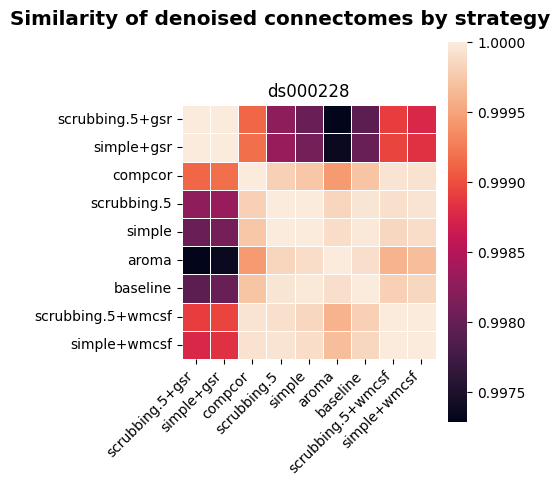

In [7]:
avg_connectomes = load_connectome_similarity(PATH_ROOT, DATASETS, FMRIPREP_VERSION)

fig = plot_connectome_similarity(avg_connectomes,
                                 horizontal=False,
                                 strategy_order=CUSTOM_ORDER,
                                 show_colorbar=True)

plt.show()                       # inline display for the notebook
# fig.savefig("connectome_similarity.png", dpi=300, transparent=True)

Seems like the biggest differences are mainly caused by introduction of GSR, or use of compcor components. 